<a href="https://colab.research.google.com/github/KD1994/EIP-Sessions/blob/master/Week-5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
BEST_HVC_MODEL.h5  gdrive/  hvc_annotations.csv  resized/  sample_data/


# Import Packages

In [0]:
%tensorflow_version 1.x
%matplotlib inline

import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os

from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import keras
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.models import load_model, Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


# Load Data

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


# Preprocessing

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
# from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6950,resized/6951.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
5035,resized/5036.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4410,resized/4411.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


# Data Generator

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

- - - - - - - - - - - - - - - - 
Image: 12, Shape: (224, 224, 3)
- - - - - - - - - - - - - - - - 


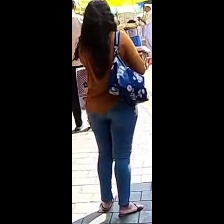

- - - - - - - - - - - - - - - - 
	Ground Truth
- - - - - - - - - - - - - - - - 
['gender', 'female']
['imagequality', 'Average']
['age', '25-35']
['weight', 'slightly-overweight']
['carryingbag', 'Daily/Office/Work Bag']
['footwear', 'CantSee']
['emotion', 'Neutral']
['bodypose', 'Side']


In [0]:
# Show a random image from the Batch
no = np.random.randint(0, images.shape[0])
print('- - '*8)
print('Image: {}, Shape: {}'.format(no, images[no].shape))
print('- - '*8)
cv2_imshow(images[no])
print('- - '*8)
print('\tGround Truth')
print('- - '*8)
print(_gender_cols_[np.argmax(targets['gender_output'][no])].split('_'))
print(_imagequality_cols_[np.argmax(targets['image_quality_output'][no])].split('_'))
print(_age_cols_[np.argmax(targets['age_output'][no])].split('_'))
print(_weight_cols_[np.argmax(targets['weight_output'][no])].split('_'))
print(_carryingbag_cols_[np.argmax(targets['bag_output'][no])].split('_'))
print(_footwear_cols_[np.argmax(targets['pose_output'][no])].split('_'))
print(_emotion_cols_[np.argmax(targets['footwear_output'][no])].split('_'))
print(_bodypose_cols_[np.argmax(targets['emotion_output'][no])].split('_'))

# Plot Accuracy and Loss

In [0]:
def plot_model_history(model_history):
    fig, ax = plt.subplots(8, 2,figsize=(15, 30))

    val_acc_list = ['val_gender_output_acc', 'val_image_quality_output_acc',
                    'val_age_output_acc', 'val_weight_output_acc',
                    'val_bag_output_acc', 'val_footwear_output_acc',
                    'val_pose_output_acc', 'val_emotion_output_acc']
    val_loss_list= ['val_gender_output_loss', 'val_image_quality_output_loss',
                    'val_age_output_loss', 'val_weight_output_loss',
                    'val_bag_output_loss', 'val_footwear_output_loss',
                    'val_pose_output_loss', 'val_emotion_output_loss']
    train_acc_list = ['gender_output_acc', 'image_quality_output_acc',
                    'age_output_acc', 'weight_output_acc',
                    'bag_output_acc', 'footwear_output_acc',
                    'pose_output_acc', 'emotion_output_acc']
    train_loss_list = ['gender_output_loss', 'image_quality_output_loss', 
                    'age_output_loss', 'weight_output_loss',
                    'bag_output_loss', 'footwear_output_loss',
                    'pose_output_loss', 'emotion_output_loss']

    for i in range(8):
        for j in range(2):
            if j == 0:
                ax[i, j].plot(range(1,len(model_history.history[train_acc_list[i]])+1),model_history.history[train_acc_list[i]])
                ax[i, j].plot(range(1,len(model_history.history[val_acc_list[i]])+1),model_history.history[val_acc_list[i]])
                title = train_acc_list[i].split('_')[0] + ' Accuracy'
                ax[i, j].set_ylabel('Accuracy')
                ax[i, j].legend([train_acc_list[i], val_acc_list[i]], loc='best')
            else:
                ax[i, j].plot(range(1,len(model_history.history[train_loss_list[i]])+1),model_history.history[train_loss_list[i]])
                ax[i, j].plot(range(1,len(model_history.history[val_loss_list[i]])+1),model_history.history[val_loss_list[i]])
                title = val_acc_list[i].split('_')[1] + ' Loss'
                ax[i, j].set_ylabel('Loss')
                ax[i, j].legend([train_loss_list[i], val_loss_list[i]], loc='best')
            ax[i, j].set_title(title)
            ax[i, j].set_xlabel('Epoch')
            ax[i, j].grid(True)  
    plt.tight_layout()
    plt.show()    

In [0]:
checkpoint = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'BEST_HVC_MODEL.h5'), monitor='val_loss', verbose=1, 
                             save_best_only=True, period=1)
callback = [checkpoint]

# Training & Evaluation

In [0]:
model = Sequential()
 
model.add(Convolution2D(32, 3, activation='relu',  use_bias=False,input_shape=(224,224,3))) #222
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 7, strides=2, padding='same', use_bias=False, activation='relu')) #111
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, use_bias=False,activation='relu')) #109
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, use_bias=False,activation='relu')) # 107
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, use_bias=False, activation='relu')) # 105
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, use_bias=False, activation='relu')) # 103
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, use_bias=False, activation='relu')) # 101
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, use_bias=False,activation='relu')) # 99
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, 1, use_bias=False, activation='relu')) # 99
model.add(MaxPooling2D(pool_size=(2, 2))) # 49

model.add(Convolution2D(32, 3, use_bias=False,activation='relu')) # 47
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2))) # 23

model.add(Convolution2D(32, 3, use_bias=False,activation='relu')) # 21
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 1, use_bias=False, activation='relu')) # 21
model.add(MaxPooling2D(pool_size=(2, 2))) #10

model.add(Convolution2D(32, 3, use_bias=False, activation='relu')) # 8
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, 1, activation='relu')) # 8

neck = model.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=model.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 864         conv2d_1_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 222, 222, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
losses = {"gender_output": "binary_crossentropy", 
    "image_quality_output": "categorical_crossentropy", 
    "age_output": "categorical_crossentropy",
    "weight_output": "categorical_crossentropy",
    "bag_output": "categorical_crossentropy",
    "footwear_output": "categorical_crossentropy",
    "pose_output": "categorical_crossentropy",
    "emotion_output": "categorical_crossentropy"
    }
    
loss_weights = {
          "gender_output": 0.1, "image_quality_output": 1.0, "age_output": 1.0, 
          "weight_output": 0.3, "bag_output": 0.3, 
          "footwear_output": 0.3, "pose_output": 0.3, 
          "emotion_output": 0.4}

opt=Adam(lr=0.001, beta_1=0.95, beta_2=0.999, amsgrad=False)

model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen, 
    epochs=50,
    verbose=1,
    callbacks=callback
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
360/360 [==============================] - 79s 218ms/step - loss: 4.0410 - gender_output_loss: 0.6829 - image_quality_output_loss: 0.9966 - age_output_loss: 1.4390 - weight_output_loss: 1.0074 - bag_output_loss: 0.9325 - footwear_output_loss: 1.0045 - pose_output_loss: 0.9411 - emotion_output_loss: 0.9287 - gender_output_acc: 0.5610 - image_quality_output_acc: 0.5446 - age_output_acc: 0.3910 - weight_output_acc: 0.6273 - bag_output_acc: 0.5540 - footwear_output_acc: 0.5142 - pose_output_acc: 0.6147 - emotion_output_acc: 0.7115 - val_loss: 3.9962 - val_gender_output_loss: 0.6782 - val_image_quality_output_loss: 0.9815 - val_age_output_loss: 1.4234 - val_weight_output_loss: 1.0003 - val_bag_output_loss: 0.9238 - val_footwear_output_loss: 0.9896 - val_pose_output_loss: 0.9350 - val_emotion_output_loss: 0.9223 - val_gender_output_acc: 0.5758 - val_image_quality_output_acc: 0.5510 - 

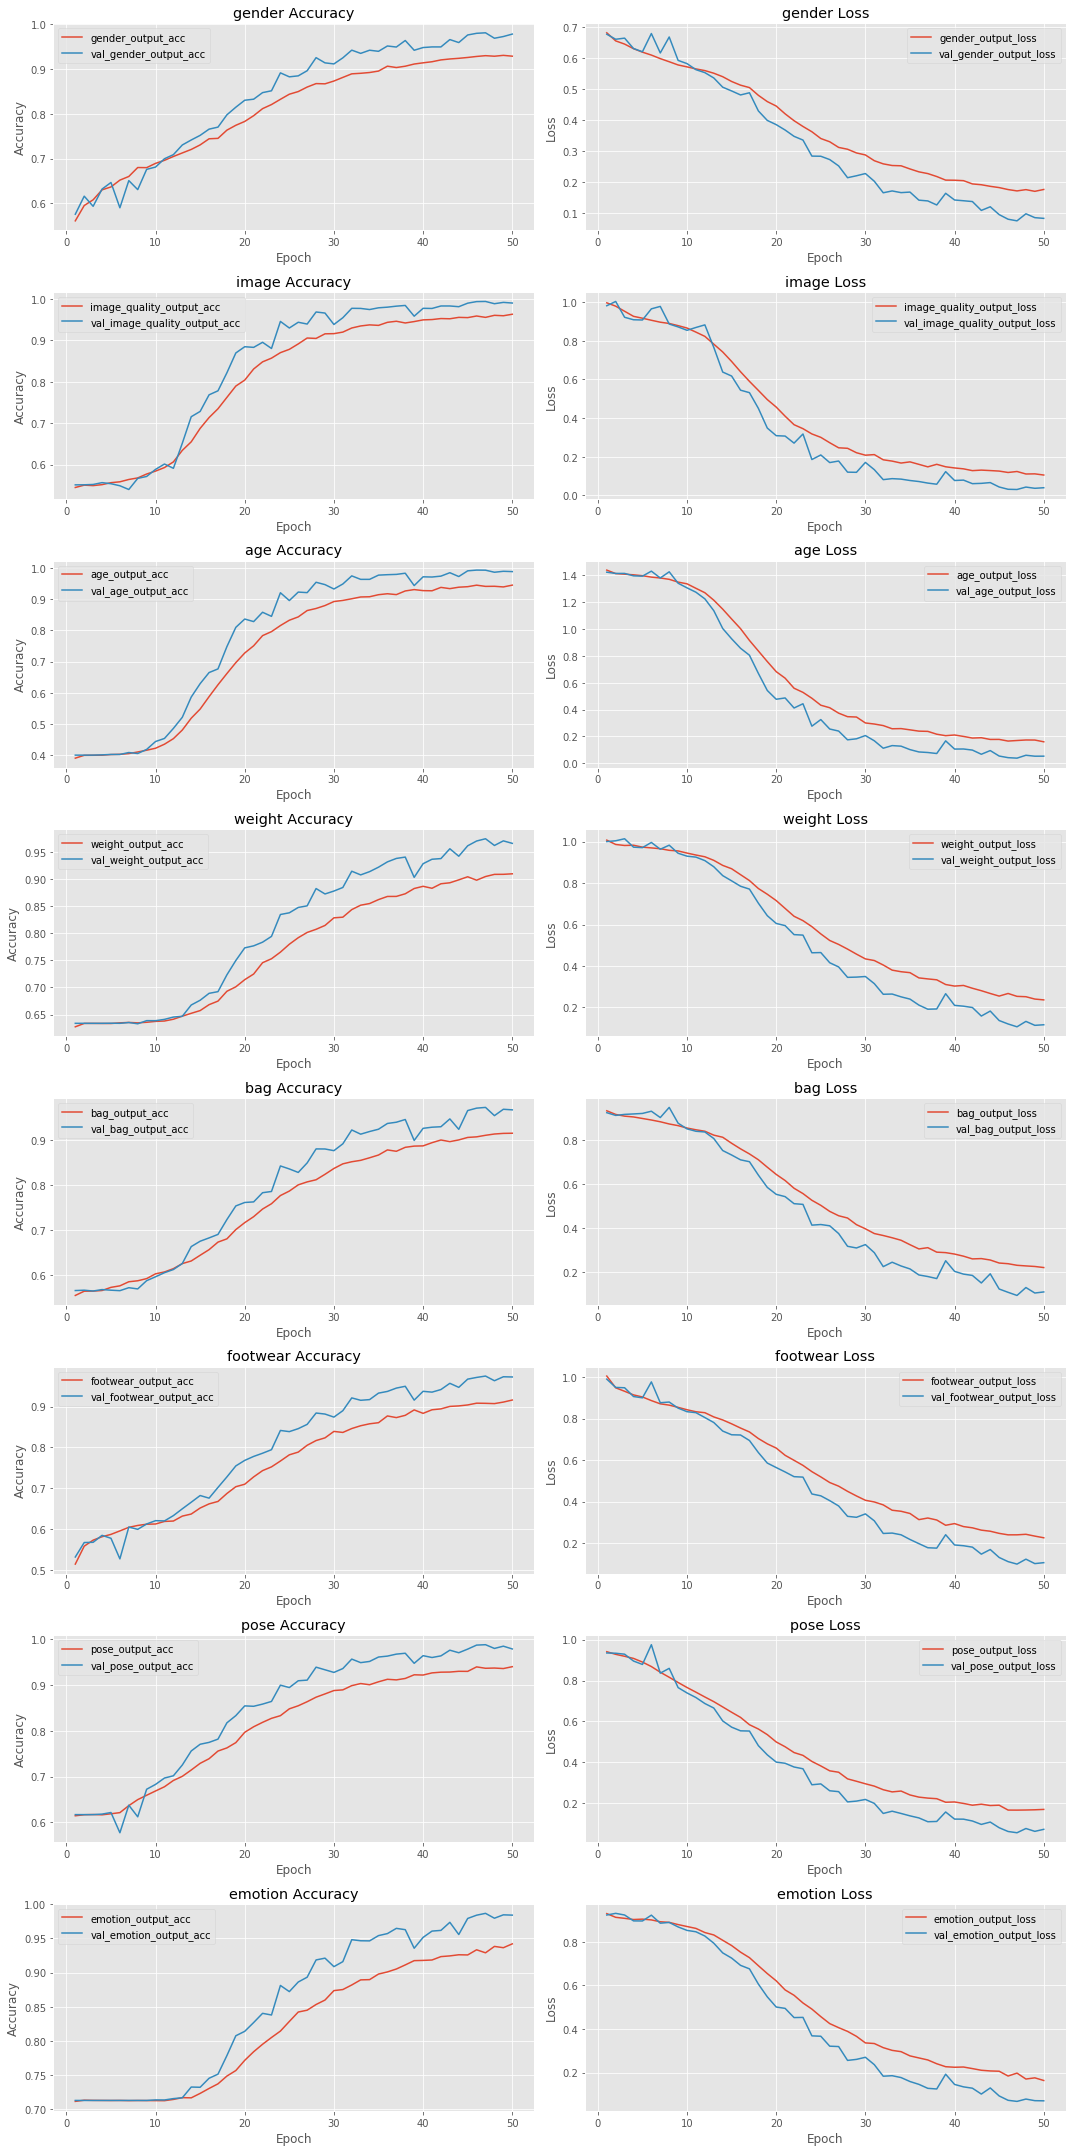

In [0]:
plot_model_history(model.history)

In [0]:
val_res = model.evaluate_generator(valid_gen, verbose=1, workers=6, use_multiprocessing=True)
dict(zip(model.metrics_names, val_res))

180/180 [==============================] - 19s 103ms/step


{'age_output_acc': 0.9875868055555556,
 'age_output_loss': 0.052596430635700624,
 'bag_output_acc': 0.9681423611111111,
 'bag_output_loss': 0.11016218314568202,
 'emotion_output_acc': 0.9840277777777777,
 'emotion_output_loss': 0.07065147958281967,
 'footwear_output_acc': 0.9728298611111111,
 'footwear_output_loss': 0.10611733283019728,
 'gender_output_acc': 0.9778645833333334,
 'gender_output_loss': 0.08309600591245625,
 'image_quality_output_acc': 0.9902777777777778,
 'image_quality_output_loss': 0.039623476176833115,
 'loss': 0.2502261357174979,
 'pose_output_acc': 0.97890625,
 'pose_output_loss': 0.07190398246877723,
 'weight_output_acc': 0.9662326388888889,
 'weight_output_loss': 0.11660327727182043}